<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ознакомимся-с-данными" data-toc-modified-id="Ознакомимся-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ознакомимся с данными</a></span></li><li><span><a href="#Подготовка-текстов" data-toc-modified-id="Подготовка-текстов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка текстов</a></span></li><li><span><a href="#Векторизация-текстов" data-toc-modified-id="Векторизация-текстов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Векторизация текстов</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LDA</a></span><ul class="toc-item"><li><span><a href="#Ключевые-слова" data-toc-modified-id="Ключевые-слова-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ключевые слова</a></span></li><li><span><a href="#Типичные-статьи" data-toc-modified-id="Типичные-статьи-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Типичные статьи</a></span></li></ul></li><li><span><a href="#Модель-NMF" data-toc-modified-id="Модель-NMF-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Модель NMF</a></span><ul class="toc-item"><li><span><a href="#Ключевые-слова" data-toc-modified-id="Ключевые-слова-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ключевые слова</a></span></li><li><span><a href="#Типичные-посты" data-toc-modified-id="Типичные-посты-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Типичные посты</a></span></li></ul></li></ul></div>

# Исследование темы наставничества в LinkedIn

**Описание проекта  и цель**

Требуется провести исследование по теме наставничества и менторства на основании контента социальной сети LinkedIn, размещенного в открытом доступе, созданного целевой аудиторией.

Задача исследования: определить топ-10 тем в направлении наставничества.

**Описание данных**

Сбор данных осуществлялся на сайт социальнй сети LinkedIn. В данных представлены ссылки на профили из ЦА (целевая аудитория), тексты публикаций. Некоторые тексты были написаны на иностранных языках, поэтому они были предварительно переведены на русский.

 - url_user - ссылка на профиль
 - text_post  - текст публикации
 - language  - язык публикации
 - translated_text - переведенный текст
 
 
 **План работы**
 
1. Предобработка данных
    - Ознакомление с данными
    - Подготовка текстов
    - Векторизация текстов
2. Моделирование
   - модель LDA
   - модель NMF
   - Ключевые слова для каждой модели
   - Типичные статьи для каждой модели
3. Выводы

# Предобработка данных

## Ознакомимся с данными

In [54]:
# Импорт библиотек
import re
import json
import random
import warnings 

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Ознакомимся с датасетом 
df = pd.read_csv('data/all_data_translated.csv')

# выведем первые строки
df.head()

,url_user,text_post,language,translated_text
0,https://www.linkedin.com/in/korenevich/,['Приложение которое из голоса раскидывает зад...,ru,['Приложение которое из голоса раскидывает зад...
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...
3,https://www.linkedin.com/in/korenevich/,"'Кто хорошо потрудился на этой неделе, тот я....",ru,"'Кто хорошо потрудился на этой неделе, тот я...."
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...


Изначально данные собраны на разных языках. Дело в том, что рускоязычные спикеры пишут как на русском, там и на английском языках, поскольку социальная сеть предназначена для международной коммуникации в том числе.

In [4]:
# Проверим размерность
df.shape

(11146, 4)

In [5]:
# Проверка на дубликаты
df.duplicated().sum()

211

In [6]:
# Удалим дубликаты 
df = df.drop_duplicates(keep='last')

In [7]:
# Проверим пропуски
df.isna().sum()

url_user           0
text_post          0
language           0
translated_text    0
dtype: int64

In [8]:
# Проверим есть ли строки, в которых нет текста
df.loc[df['translated_text'] == '']

,url_user,text_post,language,translated_text


In [9]:
# Количество профилей
df.url_user.nunique()

1012

In [10]:
# Посомотрим на итоговые результаты
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10935 entries, 0 to 11145
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url_user         10935 non-null  object
 1   text_post        10935 non-null  object
 2   language         10935 non-null  object
 3   translated_text  10935 non-null  object
dtypes: object(4)
memory usage: 427.1+ KB


In [11]:
# Посмотрим на тексты публикаций - случайным образом сэмплируем несколько примеров
df['translated_text'].values[[random.sample(range(len(df)), k=5)]]

array([['💡💻 📰 ✨ Рада поделиться своими мыслями о защите среды удаленной работы в последней статье Forbes под названием «13 экспертных стратегий, помогающих защитить среду удаленной работы». Крайне важно ограничить доступ сотрудников к важным данным, чтобы обеспечить безопасность данных и защитить конфиденциальную информацию. Ознакомьтесь с полным текстом статьи на веб-сайте Forbes, чтобы получить ценную информацию и эффективные стратегии. Давайте вместе создадим безопасную и надежную рабочую среду! Следите за обновлениями и ценной информацией 😉',
        'Библиотечное приложениеКоличество цифровых библиотек быстро растет. Все мы счастливы держать книгу в руках, но... Экология, время, скорость жизни, деньги - все способствует тому, что, пожалуй, ни один человек не читал электронное издание хотя бы раз в жизни. «Современная библиотека» спроектирована таким образом, чтобы упростить обслуживание, чтобы не нарушать предвкушение чтения. #электронная книга #bookonlinestore#tabletapp #планшет'

In [12]:
# Посмотрим какие языки присутсвуют в тексте
df['language'].unique()

array(['ru', 'ro', 'en', 'uk', 'hr', 'mk', 'ca', 'et', 'no', 'bg', 'fr',
       'sl', 'sq', 'fi', 'id', 'cs', 'it', 'af', 'tl', 'pt', 'sv', 'de',
       'es', 'nl', 'cy', 'da', 'sw', 'pl', 'tr', 'so', 'ar', 'lt', 'vi',
       'he', 'hu', 'sk'], dtype=object)

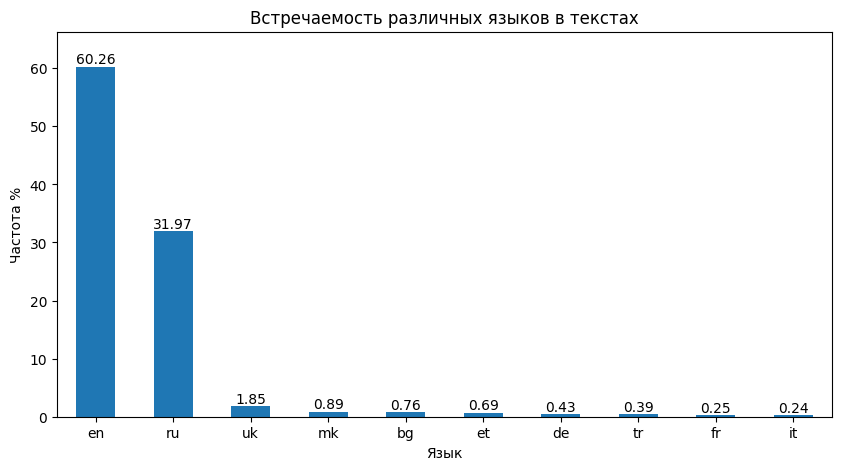

In [13]:
# Исследуем топ-10 языков по встречаемости
lang_freq = (df['language'].value_counts(normalize=True).round(4)[:10])*100

ax = lang_freq.plot(kind='bar', figsize=(10, 5), title='Встречаемость различных языков в текстах',
             xlabel='Язык', ylabel='Частота %', legend=False, rot = 0)

ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)

Таким образом, подавляющее число постов (более 60%) написано на английском языке. На втором месте - русские тексты (~ 32%).

In [14]:
# Оценим, как много текстов написано не на 'ru' и 'en'
len(df.loc[~df['language'].isin(['ru', 'en'])])

850

Язык отличный от английского и русского встречается в 850 текстах. Под другими языками могли определиться тексты, содержащие хэштеги, профессионализмы и жаргон. 

In [15]:
# Добавим дополнительнй признак - длина текста
df['len_text'] = df['text_post'].apply(lambda x:len(x))

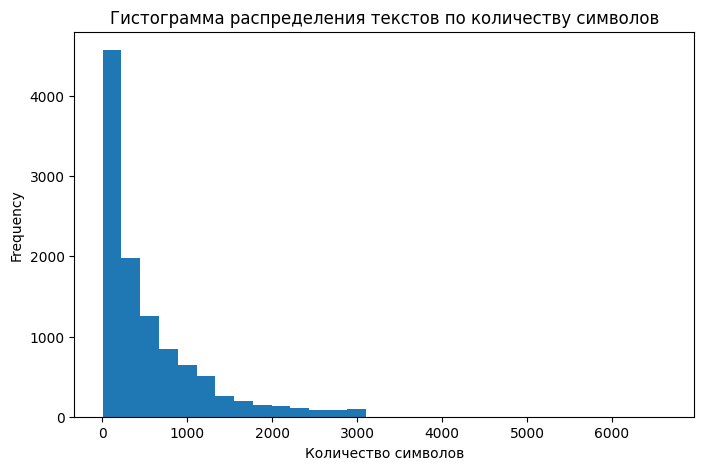

In [16]:
# Построим гистограмму распределения длин
plt.figure(figsize=(8,5))
df['len_text'].plot.hist(bins = 30)

plt.title('Гистограмма распределения текстов по количеству символов')
plt.xlabel('Количество символов')
plt.show()

In [17]:
# Выведем статистику по количеству символов
df['len_text'].describe()

count    10935.000000
mean       545.891724
std        623.084776
min          2.000000
25%        110.500000
50%        307.000000
75%        762.000000
max       6638.000000
Name: len_text, dtype: float64

Видно, что длина некоторых текстов достигает 6638 знаков, а минамальная длина равна двум знакам. Таким образом, 25% данных короче 110 символов. Посмотрим на примеры текстов и оценим несут ли они в себе полезную информацию.

In [18]:
# Тексты короче 30 символов
df.loc[df['len_text'] < 30, 'translated_text']

91                    'оп и я тут тоже 😄
98           'Очень близок такой подход.
187                            'Хорошее)
209                      'Лучший способ!
210           'Будет что-нибудь сегодня?
                      ...               
11108    Умное производство — это круто.
11109                      Вперед, Илон!
11111        Дизайн базы данных DataCamp
11140                      Хорошая схема
11145                           DataCamp
Name: translated_text, Length: 780, dtype: object

In [19]:
# Тексты короче 100 символов
df.loc[df['len_text'] < 100, 'translated_text']

0        ['Приложение которое из голоса раскидывает зад...
3         'Кто хорошо потрудился на этой неделе, тот я....
5         '🔥Вот и приложение под iOS🔥 Очень ждал тк в м...
19                'Черканула о постановке карьерных целей.
29        'Пока мы на каникулах немного развлекательног...
                               ...                        
11133    Том Торн #нанимает. Знаете кого-нибудь, кому э...
11136    Посмотрите мое проверенное достижение от The L...
11140                                        Хорошая схема
11143         Обобщенные линейные модели DataCamp в Python
11145                                             DataCamp
Name: translated_text, Length: 2506, dtype: object

Удалим тексты короче 100 символов. Предполагаем, что это как правило текст, который не несет нужной нас информации - это может быть подпись к картинке или видео, набор хэштэгов и пр.

In [20]:
# Удалим наблюдения с текстами менее 100 символов
df_len_text_100 = df.loc[df['len_text'] > 100]

In [21]:
# Количество наблюдений
len(df_len_text_100)

8413

По завершению анализа исходных данных можно заключить:

   - размер исходного датасета для анализа составляет 11146 строк на 4 столбца. Представлены ссылки на профили пользователей, тексты публикации, язык публикации и переведенный на русский язык текст публикации;
   - пропусков в данных нет, но есть дубликаты;
   - текстах видны смайлы, хэштэги, служебные символы, слова и абревиатуры на английском, ссылки; 
   - тексты написаны на разных языках, количестов постов не на русском и не на английском языках - 850
   - выявлено, что 2506 текстов из 11146 "короткие" - т.е. их длина менее 100 символов. Из них 865 текстов короче 30 символов. Что составляет 22% и 8% от исходных данных.
   - максимальныя длина текста - 6638 символов, а минимальная - 2 символа.
   
   
На следующем этапе будут использоваться данные (8413 текстов) где размерность текстов в постах составляет более 100 символов. Кроме того, тексты будут очищены от символов, смайлов и стоп-слов. 

## Подготовка текстов

Далее проведем подготовку текстов: проведем лемматизацию и токенизацию текстов, а также очистим от "мусорных" символов.

In [22]:
# определим модель spacy
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

In [23]:
# Складываем все тексты в один список
texts = df_len_text_100["translated_text"].tolist()

In [24]:
# Лемматизация текста для текстов, длиннее 100 символов
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    try:
        res.append([token.lemma_ for token in doc])
    except:
        print(doc)

In [25]:
# Сохраним результат лемматизации
with open("lemmas_100.json", "w") as fid:
    json.dump({"lemmas": res}, fid)

In [40]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
[", ".join(text) for text in random.SystemRandom().sample(res, 3)]

['я, только, что, получил(а, ), значок, за, навык, ", t, -, sql, ", ., кто, хотеть, быть, следующий, ?, пройти, тест, на, проверка, навык, #, linkedinskillassessment, .',
 'всем, известный, ,, что, нельзя, приготовить, омлет, ,, не, разбить, несколько, яйцо, ., иногда, вы, просто, не, мочь, избежать, неудача, ., но, мы, не, отрицать, неудача, —, мы, на, них, учиться, ., и, я, собираться, рассказать, вам, о, случай, ,, который, мы, узнать, ., так, случиться, с, одним, из, наш, проект, не, так, давно, ., клиент, запустить, промо, -, кампания, для, свой, сайт, (, которую, мы, написать, ), для, привлечение, клиент, ., он, не, предупредить, нас, об, это, ,, поэтому, сервер, выйти, из, строй, из, -, за, высокий, активность, на, сайт, ., К, сожаление, ,, в, тот, раз, исправить, это, не, удаться, ,, так, как, сервер, сайт, не, масштабировался, ., на, данный, момент, на, сайт, около, 15000, пользователь, ., мы, как, можно, скорее, позвонить, наш, клиент, ,, чтобы, утвердить, рабочий, процесс, д

Удалим знаки препинания, цифры и слова, содержащие цифры. А также иностранные слова, которые не перевелись. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.

In [41]:
# определим регулярное выражение
word_pattern = re.compile("^[а-яё]*$")

In [42]:
# определим функцию для очистки текста
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [43]:
# очистим текст
corpus = list(map(remove_symbols, res))

In [44]:
# Определим как часто встречаются к корпусе пустые списки (удалены все слова)
corpus_empty = [li for li in corpus if len(li) < 1]
len(corpus_empty)

14

In [45]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
[", ".join(text) for text in random.SystemRandom().sample(corpus, 3)]

['создать, сообщество, непростой, создать, амбициозный, сообщество, с, больший, цель, в, тысяча, раз, сложный, но, мы, это, сделать, особенно, если, вы, присоединитесь, и, помочь, нам, как, видеть, у, нас, запланировать, очень, много, инициатива, и, чем, больше, человек, быть, задействовать, в, реализация, тем, быстрый, мы, получить, к, нам',
 'событие, которое, нельзя, пропустить, если, вы, заниматься, иб, присоединяться, сентябрь, к, онлайн, конференции, практика, по, кибербезопасности, рассказать, как, обнаруживать, расследовать, и, отражать, кибератаки, что, будет, доклад, и, мастер, класс, от, пентестеров, специалист, по, мониторинг, и, расследование, инцидент, из, лаборатория, касперский, инфосистемы, джет, синклит, и, задание, для, отработка, практический, навык, в, формат, игровой, обучение, забронируйте, три, день, на, полезный, контент, поиск, низко, висеть, фрукт, в, ит, инфраструктуре, раскладывать, атака, по, эффективный, харденинг, ит, инфраструктура, типовой, сценарий, и

In [55]:
# Зададим собственный список стоп-слов
stop_words_custom = ['это', 'наш', 'ваш', 'весь', 'это', 'наш', 'лс', 'свой', 'весь', 'год', 'якщо', 'дуже', 'ви', 
                     'але', 'роботи', 'буде', 'це', 'ми', 'як', 'що', 'хто', 'чи', 'цей', 'зараз', 'хто', 'чи', 'цей', 'час',
                    'мария', 'эй']

In [56]:
# Дополнительные стоп-слова для руссковго языка
stop_words_additional = ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь",
                         "будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная",
                         "важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг",
                         "ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне",
                         "вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать",
                         "восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми",
                         "всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз",
                         "говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно",
                         "даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый",
                         "двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел",
                         "делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго",
                         "должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое",
                         "другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать",
                         "же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем",
                         "здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно",
                         "иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как",
                         "какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая",
                         "которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли",
                         "лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее",
                         "меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная",
                         "многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может",
                         "может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над",
                         "надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша",
                         "наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного",
                         "нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой",
                         "никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну",
                         "нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды",
                         "однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно",
                         "остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать",
                         "плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить",
                         "помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом",
                         "потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь",
                         "пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше",
                         "ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим",
                         "самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего",
                         "своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас",
                         "семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько",
                         "слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем",
                         "спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть",
                         "считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя",
                         "твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того",
                         "тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут",
                         "ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть",
                         "хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый",
                         "четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать",
                         "шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту",
                         "я","являюсь", "окоманюк", "леонардо", "силиконовый", "силиконовой", "чернобыль", "университетподать",
                        "щелчки", "постю", "ури", "мрт", "труха", "вооружиться", "пот", "запорожье", "айзека", "питерский", 
                         "ледовый", "подбираю", "топор", "капать", "правильном", "фотосессия"]

In [58]:
# Стоп-слова spacy
stopwords_spacy = model.Defaults.stop_words

print(len(stopwords_spacy))

768


In [121]:
# Объединим стоп-слова
stop_words = stopwords.words('russian') + stop_words_custom + stop_words_additional# + list(stopwords_spacy)
len(stop_words)

762

## Векторизация текстов

Далее векторизируем полученный корпус. 

In [122]:
# Посчитаем IDF всех наших слов, и отсечем слова с самым большим idf(очень редкие) и с самым маленьким
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

In [123]:
# Объединим списки слов в предложения
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['почему основатель любой бизнес обязанный уметь продавать навык продажа десяток стартап проплывать у меня перед глаз каждый месяц кто то приходить за разовый совет кто то с просьба о долгосрочный сотрудничество каждый новый встреча для меня уникальный и я всегда с свой сторона стараться подготовиться посмотреть проект рынок конкурент каждый встреча ждать с нетерпение ждать потому что увидеть новый проект новый идея новый человек который хотеть изменить этот мир к хороший понимать что это нифига не просто и естественно я рассчитывать что этот человек продать мне свой идея ярко рассказать о свой проект команда о свой победа и конечно же трудность человек который уметь продавать видно с первый минута разговор я хотеть обратить внимание на то что именно продавать а не машинальный впаривать по ранее заготовить скрипт такой фаундеры выделяться среди других они запоминаться и сказать по секрет я наблюдать за многими из них даже если запрос фаундера не совпадать с мой компетенция и мы больше 

In [124]:
# трансформируем корпус
x = tfidf.fit_transform(docs)

In [125]:
# проверим размерность
x.shape

(8413, 4081)

In [126]:
#сохраним id токенов
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

# Моделирование

In [127]:
# Необходимые функции
def topic_tokens(n_topics, model, num_key_words):
    """Принимает на вход количество тем, модель и количество ключевых слов, которые нужно вывести.
    Выводит номер темы и соотвествющие ключевые слова"""
    for i in range(n_topics):
        c = model.components_[i, :]
        topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-num_key_words:]]
        print("Тема",i, ":")
        print(", ".join(topic_tokens[::-1]))
        print("\n ")

def typical_posts(n_topics, topics):
    """Принимает на вход количество тем, результат работы модели.
    Выводит типичный пост по каждой теме"""
    for i in range(n_topics):
        doc_id = np.argmax(topics[:, i])
        print("Тема ", i)
        print(df_len_text_100.iloc[doc_id]["translated_text"])
        print("\n")
        


In [144]:
def plot_tsne(n_clusters, topics):
    """Принимает на вход количество кластеров и результат работы модели.
    Возвращает визуализацию тематических кластеров."""
    
    # Определим количество кластеров
    kmeans = KMeans(n_clusters)

    # Обучим модель
    clust_labels = kmeans.fit_predict(topics)
    clust_centers = kmeans.cluster_centers_

    # Объединим результат
    embeddings_to_tsne = np.concatenate((topics,clust_centers), axis=0)

    # TSNE это инструмент для визуализации многомерных данных
    tSNE =  TSNE(n_components=2, perplexity=15)
    tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
    tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)
    
    # Выделим кластеры
    clust_indices = np.unique(clust_labels)

    # Далее определим параметры визуализации
    clusters = {clust_ind : [] for clust_ind in clust_indices}
    for emb, label in zip(tsne_embeddings, clust_labels):
        clusters[label].append(emb)

    for key in clusters.keys():
        clusters[key] = np.array(clusters[key])

    colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))
    
    # Выведем полученный результат
    plt.figure(figsize=(5,5))
    for ind, color in zip(clust_indices, colors):
        x = clusters[ind][:,0]
        y = clusters[ind][:,1]
        plt.scatter(x, y, color=color)

        centroid = centroids_embeddings[ind]
        plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

    plt.show()

## LDA

In [128]:
# Зададим количество тем
n_topics = 10

In [129]:
# Определим модель
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=30,
                                random_state=31)

In [132]:
# Транформируем корпус 
topics_lda = lda.fit_transform(x)

In [133]:
# Проверим размерность
topics_lda.shape

(8413, 10)

Получили массив размера **8413x10**. Строки здесь - отдельные тексты, а колонки - 10 выделенных тем. В каждой ячейке стоит вероятность того, что данный текст относится к данной теме. 

### Ключевые слова

Далее выделем 10 ключевых слов для каждой темы.

In [134]:
# Выведем номер темы и соотвествющие ключевые слова
topic_tokens(n_topics, lda, 10)

Тема 0 :
вакансия, разработчик, искать, резюме, опыт, поиск, команда, привет, проект, интересный

 
Тема 1 :
проект, компания, команда, разработка, бизнес, продукт, клиент, приложение, опыт, решение

 
Тема 2 :
иб, кибербезопасность, значок, навык, инфобез, следующий, тест, пройти, проверка, справляться

 
Тема 3 :
украина, украинец, военный, ребёнок, пожертвование, семья, поддержать, российский, киев, армия

 
Тема 4 :
сертификат, сообщить, рад, век, наступать, русские, пусть, сертификация, солдат, курс

 
Тема 5 :
дизайн, разработка, страница, услуга, сайт, веб, приложение, интерфейс, посетить, бизнес

 
Тема 6 :
логотип, закончить, электромобиль, зарядка, проверить, курс, оценить, погнать, видео, вкладка

 
Тема 7 :
удовольствие, сообщать, начинать, должность, компания, сертификат, лендинг, сварка, захотеться, прочтение

 
Тема 8 :
благодарить, заранее, возможность, предложить, совет, поддержка, признателен, здравствовать, привет, роль

 
Тема 9 :
добро, пожаловать, запустить, тради

По полученным ключевым словам можно составить представление о содержании той или иной темы.

### Типичные статьи

Далее определим типичные посты для каждой темы.

In [136]:
# Выведем самый типичный пост для каждой темы
typical_posts(n_topics, topics_lda)

Тема  0
 'У меня классные новости для разработчиков, которые сейчас ищут работу. Вот уже более несколько месяцев я работаю HR-ментором в команде < codereview /> (https://is.gd/TrYEJV). Вместе с другими менторами мы помогаем ребятам составить цепляющее резюме, учим писать сопроводительные письма, преодолевать страх собеседований, прокачиваем их hard скиллы и даем направление, как развиваться в профессии дальше. Мы сопровождаем вас на каждом шагу, от отклика на вакансию до выбора и подписания оффера.Заходите к нам на сайт (https://is.gd/TrYEJV), чтобы узнать больше и записаться ко мне на бесплатную консультацию)Всем удачи в поиске работы!


Тема  1
У меня было много вопросов о том, что мы видим в Deel в этой рабочей среде. Как работодатели реагируют на сегодняшнюю реальность и что показывают наши данные? 🧵👀Deel занимается HR для глобальных команд — адаптацией, выплатами и даже увольнениями. Вот что в тренде у сотен тысяч работников в более чем 100 странах 🌎1/ Споры о местной и глобальной

На основании полученных результатов можно предположить названия тем:
   - Тема 0 - проектное сотрудничество;
   - Тема 1 - внешняя политика;
   - Тема 2 - коучинг;
   - Тема 3 - предложение IT услуг; 
   - Тема 4 - менторство начинающих специалистов;
   - Тема 5 - новости IT рынка;
   - Тема 6 - обучение IT профессиям;
   - Тема 7 - IT рекрутмент;
   - Темы 8 и 9 также посвящены поиску работы.

In [137]:
# Словарь соответствия номера темы и ее названия
topic_dict = {0 : 'проектное сотрудничество',
              1 : 'внешняя политика',
              2 : 'коучинг',
              3 : 'предложение IT услуг',
              4 : 'менторство начинающих специалистов',
              5 : 'новости IT рынка',
              6 : 'обучение IT профессиям',
              7 : 'IT рекрутмент',
              8 : 'поиск работы',
              9 : 'поиск работы'}

In [138]:
# Добавим столбец с темой для каждого наблюдения
df_len_text_100['topic'] = topics.argmax(axis=1)
df_len_text_100['topic'] = df_len_text_100['topic'].apply(lambda key: topic_dict[key])

# Посмотрим на результат
df_len_text_100.head()

,url_user,text_post,language,translated_text,len_text,topic,probability
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...,2973,внешняя политика,0.859556
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...,2975,внешняя политика,0.517804
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...,1044,внешняя политика,0.784148
6,https://www.linkedin.com/in/korenevich/,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,ru,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,2576,внешняя политика,0.703562
7,https://www.linkedin.com/in/korenevich/,"'Казалось бы, ну какая нам разница, где и как...",ru,"'Казалось бы, ну какая нам разница, где и как...",2034,внешняя политика,0.462844


In [139]:
# Определим какие темы представлены чаще всего
df_len_text_100['topic'].value_counts()

topic
внешняя политика                      6607
проектное сотрудничество               754
поиск работы                           226
новости IT рынка                       223
коучинг                                171
IT рекрутмент                          148
предложение IT услуг                    99
менторство начинающих специалистов      96
обучение IT профессиям                  89
Name: count, dtype: int64

Видно, что в датасет попало много постов с темой "внешней политики". Очевидна, нужна другая стратегия поиска постов.

In [140]:
# Добавим столбец с вероятностью принадлежности выбранной теме для каждого наблюдения
df_len_text_100['probability'] = topics.max(axis=1)

#посмотрим на результат
df_len_text_100.head()

,url_user,text_post,language,translated_text,len_text,topic,probability
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...,2973,внешняя политика,0.879818
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...,2975,внешняя политика,0.841049
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...,1044,внешняя политика,0.677442
6,https://www.linkedin.com/in/korenevich/,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,ru,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,2576,внешняя политика,0.809520
7,https://www.linkedin.com/in/korenevich/,"'Казалось бы, ну какая нам разница, где и как...",ru,"'Казалось бы, ну какая нам разница, где и как...",2034,внешняя политика,0.890893


In [141]:
# Выберем топ-100 текстов с максимальной вероятностью
top_100 = (df_len_text_100[['translated_text', 'topic', 'probability']]
           .sort_values(by = 'probability', ascending  = False).iloc[:100])

#посмотрим на результат
top_100

,translated_text,topic,probability
10534,"У меня было много вопросов о том, что мы видим...",внешняя политика,0.922118
9174,В современном цифровом ландшафте удаленная раб...,внешняя политика,0.921700
8996,"Хорошо, я обещал поделиться некоторыми из лучш...",внешняя политика,0.920567
8400,В быстро меняющемся мире технологической эволю...,внешняя политика,0.919347
8384,«Преобразование будущего искусственного интелл...,внешняя политика,0.917976
...,...,...,...
1417,"29 ноября участвую в конференции ""Цифровизация...",внешняя политика,0.901507
10805,"📢 Ищу роль разработчика iOS! 📱🔍Здравствуйте, з...",внешняя политика,0.901486
7548,"Считаете ли вы, что компании-разработчики прог...",внешняя политика,0.901333
6342,Продолжая серию о создании сайтов компаний с и...,внешняя политика,0.901312


На данном этапе выделили топ-100 постов с большей частотой встречающихся слов. Эти данные в дальнейшем могут использоваться для анализа целевой аудитории.

In [142]:
# Проверим, к каким темам относятся топ-100 текстов
top_100.topic.value_counts()

topic
внешняя политика    100
Name: count, dtype: int64

Алгоритм увереннее всего определяет тему "внешняя политика", что логично, так как именно эта тема представлена максимально (6607 текстов).

In [143]:
# Попробуем оценить насколько уверен алгоритм в остальных темах
df_len_text_100.groupby('topic').agg({'probability' : 'mean', 
                                      'topic' : 'count'}).sort_values(by = 'probability', ascending = False)

,probability,topic
topic,,
внешняя политика,0.761264,6607
поиск работы,0.708762,226
коучинг,0.683228,171
IT рекрутмент,0.674242,148
новости IT рынка,0.642640,223
менторство начинающих специалистов,0.640245,96
обучение IT профессиям,0.629076,89
проектное сотрудничество,0.588195,754
предложение IT услуг,0.563181,99


Лучшие по средней вероятности темы - `внешняя политика`, `поиск работы`, `коучинг` не смотря на то, что тема  `коучинг` представлена только в 171 текстах. А вот темы `обучение IT профессиям`, `проектное сотрудничество`, `предложение IT услуг` определяются хуже всего. Вероятно, сказывается небольшое количество данных. Тема `менторство начинающих специалистов` находится на 6 месте.

Попробуем использовать распределения тем в тексте как 'эмбеддинги' текстов, в такой интерпретации можно применять к ним алгоритмы визуализации или кластеризации, и искать уже итоговые 'эффективные ' тематические кластеры таким образом.

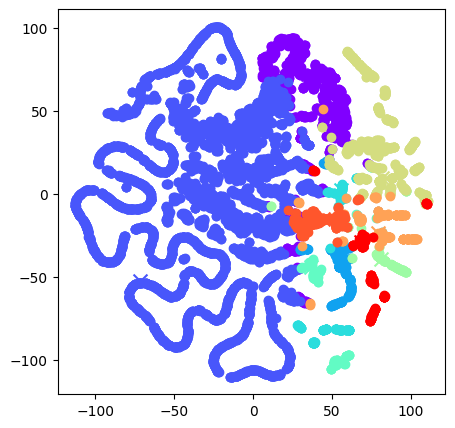

In [145]:
# Визуализация тематических кластеров
plot_tsne(10, topics_lda)

Тут хотелось бы написать, что на изображении tSNE ембеддингов, видно, что кластеры выделенные с помощью KMeans, образуют достаточно связные и чаще всего пространственно разделимые между собой множества. Но на самом деле видно, что есть над чем еще поработать.

## Модель NMF

In [150]:
# Определим модель
nmf = NMF(n_components=n_topics,
          init = 'random',
          solver = 'mu',
          beta_loss = 'kullback-leibler',
          max_iter = 1000,
          shuffle = True,
          l1_ratio = 0.02,
          random_state=42)

In [151]:
# Трансформируем корпус
topics_nmf = nmf.fit_transform(x)

In [152]:
# Оценим размеры полученной матрицы
topics_nmf.shape

(8413, 10)

Таким образом, получен датасет, где для каждого текста определена вероятность принадлежности к определнным текстам.

### Ключевые слова

In [154]:
# Выделим 10 ключевых слов для каждой темы.
topic_tokens(n_topics, nmf, 10)

Тема 0 :
дизайн, сайт, статья, проект, веб, написать, кейс, дизайнер, видео, контент

 
Тема 1 :
приложение, использовать, пользователь, функция, код, данных, мобильный, веб, инструмент, продукт

 
Тема 2 :
начинать, удовольствие, сообщать, компания, должность, желать, неделя, пара, момент, счастливый

 
Тема 3 :
программный, обеспечение, бизнес, технология, разработка, ии, стартап, интеллект, цифровой, искусственный

 
Тема 4 :
безопасность, система, данных, финансовый, компания, информационный, отчёт, облачный, платформа, инфраструктура

 
Тема 5 :
команда, клиент, проект, цель, задача, сотрудник, результат, проблема, решение, продукт

 
Тема 6 :
украина, российский, сша, логотип, пациент, недвижимость, доллар, тысяча, поддержать, миллион

 
Тема 7 :
вакансия, навык, опыт, компания, тест, специалист, иб, интервью, пройти, собеседование

 
Тема 8 :
курс, рад, обучение, мероприятие, сообщить, посетить, конференция, присоединяться, программа, встреча

 
Тема 9 :
искать, разработчик, при

### Типичные посты

In [156]:
# Определим типичные посты для каждой темы.
typical_posts(n_topics, topics_nmf)

Тема  0
Подборка сайтиков номер 6!Принес вам новую подборку вдохновения на предстоящую неделю. 13 интересных и завораживающих сайтов помогут вам найти решения для ваших проектов.⚡️ Мой топ на этой неделе Playgoals (https://playgoals.com/) , сайт отлично создает вау эффект с помощью визуала и интерактива, но при этом все уместно и аккуратно. Плюс идеи из этого референса у меня получилось интегрировать в проект совсем не связанный с играми)🔥 Поюорка:✶ https://missjourney.ai/✶ https://marsbranding.com/✶ https://lnkd.in/dFX8Wtgs✶ https://lnkd.in/dAh7jYcv✶ https://playgoals.com/✶ https://lnkd.in/dbVZmvvK✶ https://lnkd.in/dEqrm9gp✶ https://room8group.com/✶ https://lnkd.in/dAacb996✶ https://lnkd.in/dgr9RY2K✶ https://lnkd.in/dxG2CanS✶ https://teslanikola.info/✶ https://yurong.co/👾 Скорее переходи в мой телеграмм канал - https://lnkd.in/dF6vEVJXТам куча полезногоВ канале: - Design Help, файл 40+ материалов для повышения ваших скиллов- Розыгрыш консультаций по карьерному треку и разбору портфоли

На основании полученных результатов можно предположить названия тем:
   - Тема 1 - проектное сотрудничество;
   - Тема 2 - лайфхаки при поиске работы;
   - Тема 3 - образовательные статьи;
   - Тема 4 - нетворкинг/поиск сотрудника; 
   - Тема 5 - внешняя политика;
   - Тема 6 - разработка/кодинг;
   - Тема 7 - кейсы компаний/дизайн;
   - Тема 8 - рекрутмент;
   - Тема 9 - релокация;
   - Тема 10 - менторство начинающих специалистов.

In [158]:
# Словарь соответствия номера темы и ее названия
topic_dict_nmf = {0 : 'проектное сотрудничество',
              1 : 'лайфхаки при поиске работы',
              2 : 'образовательные статьи',
              3 : 'нетворкинг/поиск сотрудника',
              4 : 'внешняя политика',
              5 : 'разработка/кодинг',
              6 : 'кейсы компаний/дизайн',
              7 : 'рекрутмент',
              8 : 'релокация',
              9 : 'менторство начинающих специалистов'}

In [159]:
# Добавим столбец с номером темы для каждого наблюдения
df_len_text_100['topic_nmf'] = topics_nmf.argmax(axis=1)
df_len_text_100['topic_nmf'] = df_len_text_100['topic_nmf'].apply(lambda x: topic_dict_nmf[x])

# посмотрим на результат
df_len_text_100.head()

,url_user,text_post,language,translated_text,len_text,topic,probability,topic_nmf
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...,2973,внешняя политика,0.879818,разработка/кодинг
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...,2975,внешняя политика,0.841049,разработка/кодинг
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...,1044,внешняя политика,0.677442,релокация
6,https://www.linkedin.com/in/korenevich/,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,ru,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,2576,внешняя политика,0.809520,разработка/кодинг
7,https://www.linkedin.com/in/korenevich/,"'Казалось бы, ну какая нам разница, где и как...",ru,"'Казалось бы, ну какая нам разница, где и как...",2034,внешняя политика,0.890893,лайфхаки при поиске работы


In [160]:
# Определим какие темы представлены чаще всего
df_len_text_100['topic_nmf'].value_counts()

topic_nmf
лайфхаки при поиске работы            1054
разработка/кодинг                      924
образовательные статьи                 914
нетворкинг/поиск сотрудника            914
рекрутмент                             886
релокация                              850
проектное сотрудничество               786
внешняя политика                       757
кейсы компаний/дизайн                  665
менторство начинающих специалистов     663
Name: count, dtype: int64

In [161]:
# Добавим столбец с вероятностью принадлежности выбранной теме для каждого наблюдения
df_len_text_100['probability_nmf'] = topics_nmf.max(axis=1)

#посмотрим на результат
df_len_text_100.head()

,url_user,text_post,language,translated_text,len_text,topic,probability,topic_nmf,probability_nmf
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...,2973,внешняя политика,0.879818,разработка/кодинг,0.068602
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...,2975,внешняя политика,0.841049,разработка/кодинг,0.144294
4,https://www.linkedin.com/in/korenevich/,'Сегодня была защита дипломных работ на кафед...,ru,'Сегодня была защита дипломных работ на кафед...,1044,внешняя политика,0.677442,релокация,0.071243
6,https://www.linkedin.com/in/korenevich/,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,ru,'Кто я? Чем занимаюсь? Чем и кому могу быть п...,2576,внешняя политика,0.809520,разработка/кодинг,0.056332
7,https://www.linkedin.com/in/korenevich/,"'Казалось бы, ну какая нам разница, где и как...",ru,"'Казалось бы, ну какая нам разница, где и как...",2034,внешняя политика,0.890893,лайфхаки при поиске работы,0.060698


Выделим также топ-100 текстов, которые нашла вторая модель.

In [162]:
# Выберем топ-100 текстов с максимальной вероятностью
top_100_nmf = (df_len_text_100[['translated_text', 'topic_nmf', 'probability_nmf']]
           .sort_values(by = 'probability_nmf', ascending  = False).iloc[:100])

#посмотрим на результат
top_100_nmf

,translated_text,topic_nmf,probability_nmf
7720,Около месяца назад Россия начала военное вторж...,кейсы компаний/дизайн,0.239197
4732,"Единственный способ, которым Путин может побед...",кейсы компаний/дизайн,0.237669
6452,"31 день войны России против Украины. «Привет, ...",кейсы компаний/дизайн,0.234937
6461,12-й день войны между Россией и Украиной. Може...,кейсы компаний/дизайн,0.231560
7722,"СОХРАНИТЕ УКРАИНУ!Извините, что делаю этот пос...",кейсы компаний/дизайн,0.228702
...,...,...,...
7095,Сегодня исполняется шесть месяцев с начала ужа...,кейсы компаний/дизайн,0.156480
10298,Влияние искусственного интеллекта и машинного ...,нетворкинг/поиск сотрудника,0.156286
9243,"Мировая демистификация. Трудно поверить, но во...",кейсы компаний/дизайн,0.155980
9187,"Представьте, что у вас есть 50 задач в ваших п...",разработка/кодинг,0.155801


In [163]:
# проверим, к каким темам относятся топ-100 текстов
top_100_nmf.topic_nmf.value_counts()

topic_nmf
кейсы компаний/дизайн                 46
образовательные статьи                13
внешняя политика                      12
разработка/кодинг                      9
нетворкинг/поиск сотрудника            7
проектное сотрудничество               5
рекрутмент                             4
лайфхаки при поиске работы             2
менторство начинающих специалистов     2
Name: count, dtype: int64

Чаще всего в топ-100 встречаются темы `кейсы компаний/дизайн`, `образовательные статьи`, `внешняя политика`.

In [164]:
# Попробуем оценить насколько уверен алгоритм в остальных темах
df_len_text_100.groupby('topic_nmf').agg({'probability_nmf' : 'mean', 
                                      'topic_nmf' : 'count'}).sort_values(by = 'probability_nmf', ascending = False)

,probability_nmf,topic_nmf
topic_nmf,,
кейсы компаний/дизайн,0.082790,665
менторство начинающих специалистов,0.077071,663
внешняя политика,0.075113,757
разработка/кодинг,0.072482,924
лайфхаки при поиске работы,0.070894,1054
рекрутмент,0.069948,886
образовательные статьи,0.068497,914
нетворкинг/поиск сотрудника,0.066677,914
релокация,0.063755,850


Вероятности распределились равномерно по всем темам. Можно заметить, что данная модель плохо разделила тексты по темам, вероятность везде достаточно низкая. Можно предположить, что гиперпараметры были настроены не совсем удачно. Кроме того, похоже что имеющиеся данные в целом не кардинально отличаются друг от друга по содержанию.

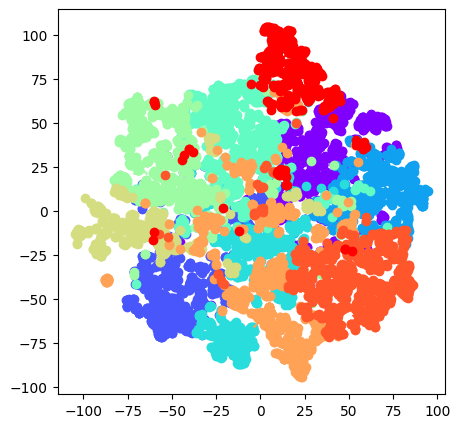

In [166]:
# Визуализация кластеров
plot_tsne(10, topics_nmf)

Визуализация явно показывает, что модель NMF с использованными гиперпараметрами не справляется со своей задачей.

# Выводы

Для проведения исследования командой написан скрипт (parser) для сбора данных в социальной сети LinkedIN, которые представляют собой ссылки на профили людей, подходящих под ЦА заказчика, тексты их постов и реакции.

Получилось собрать информацию о 158 профилях и 1125 текстов. Преобладающее количество текстов на русском языке. Но из-за небольшого их количества выполнить задачу не представлялось возможным. Поэтому, для улучшения качества прогноза модели, было решено обменяться собранными данными с другими командами.

**В итоге, для анализе использовались 1012 профилей и 11146 текстов.** Полученные тексты распределились по языкам следующим образом:
 - en - 60%
 - ru - 32%
 - uk - 2%
 - остальные - 6% (всего определлились 36 языков).

Для корректного анализа тексты предварительно переведены на русский язык.

При исследовании длин полученных текстов установлено, что максимальная достигает 6638 знаков, а минимальная длина равна двум знакам. Таким образом, 25% собранных данных короче 110 символов. Такие "короткие" тексты (предположительно подпись к картинке или видео, набор хэштэгов, смайлов и пр.) не несли в себе полезную информацию, поэтому решено удалить эти наблюдения. В итоге использовались 8413 текстов.

На этапе подготовки текстов для модели была проведена лемматизация и токенизация текстов. Также тексты были очищены от "мусорных" символов - знаков пунктуации, смайлов, иностранных слов, цифр. Удалены стоп-слова. 

Векторизация текстов производилась при помощи Tf-iDf.
На этапе подбора модели были использованы:
 - LDA - LatentDirichletAllocation
 - NMF - Non-Negative Matrix Factorization

Эффективность работы модели сложно оценить, так как нет метрик на которые можно опереться. Для выбора модели использовали здравый смысл и алгоритмы визуализации, которые позволили определить насколько хорошо модель разделяет тесты по темам.

Корректное распределение вероятности и лучшее разделение тем получено в результате применения модели LDA. Результат представлен в таблице.
 
Выделены следующие топ-10 ключевых слов по темам:

| Тема | Название темы | Количество тем |Средняя вероятность | Ключевые слова |
|----------|----------|----------|----------|----------|
| Тема 6    | новости IT рынка   | 6440 | 0.75 | решение, опыт, клиент, приложение, продукт, бизнес, разработка, команда, проект, компания |
| Тема 9    | поиск работы   | 206 | 0.71 | кибербезопасность, здравствовать, признателен, иб, поддержка, совет, предложить, возможность, заранее, благодарить |
| Тема 7    | обучение IT профессиям   | 58 | 0.66 | асинхронный, машинный, буква, испытание, карусель, видео, генеративный, проверить, курс, закончить |
| Тема 4    | предложение IT услуг   | 186 | 0.65 | рад, услуга, разработка, сообщить, сертификат, компания, должность, начинать, удовольствие, сообщать |
| Тема 8    | IT рекрутмент   | 128 | 0.63 | делиться, статья, желать, тильда, оценить, комментарий, праздник, ребята, нанимать, лендинг |
| Тема 10   | поиск работы    | 180 | 0.63 | встретиться, отличный, нетерпение, невероятный, поделиться, грузия, команда, заявка, рад, саммит |
| Тема 5    | менторство начинающих специалистов   | 611 | 0.61 | английский, команда, поиск, проект, привет, опыт, резюме, разработчик, искать, вакансия |
| Тема 3    | коучинг   | 151 | 0.60 | желать, счастливый, выходной, справляться, проверка, пройти, тест, следующий, значок, навык |
| Тема 2    | внешняя политика   | 262 | 0.57 | военный, европа, доклад, вебинар, ноябрь, март, российский, конференция, украинец, украина |
| Тема 1    | проектное сотрудничество   | 191 | 0.56 | создать, фирменный, анимация, пожаловать, сайт, добро, дизайнер, стиль, логотип, дизайн |

На основании полученных результатов можно заметить, что все посты написаны примерно про одно и то же, это: поиск работы или работников, впечатление от обучения и несколько тем посвящены коучингу и менторству начинающих специалистов. По теме наставничества целевая группа пишет немного.

**Пример визуализации разделения тем на кластеры моделью LDA**
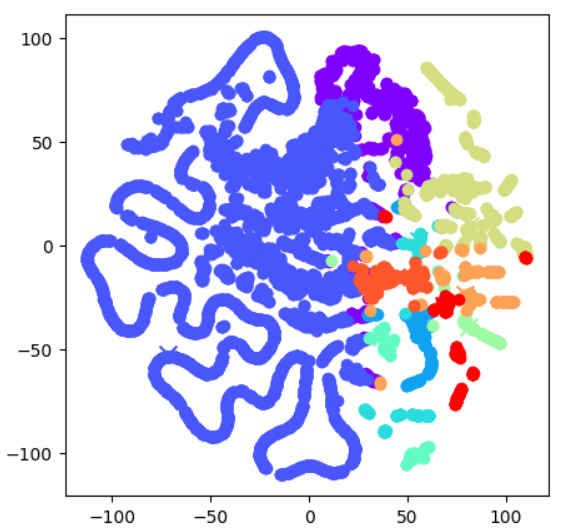
На изображении tSNE ембеддингов, видно, что кластеры выделенные с помощью KMeans, образуют достаточно связные и чаще всего пространственно разделимые между собой множества. Но так же видно, что есть над чем еще поработать.

При анализе распределения тем, с большим отрывом лидирует тема 6 (6440 текстов), на втором месте модель поставила тему 5 - 611 текстов, на третьем - 2 тема и 262 текста.

При оценке топ-100 постов, для которых модель наиболее уверенно (с большей вероятностью) определила тему выяснилось, что все эти посты отнесены к теме 6. Что логично, так как эти тексты представлены на порядок в большем количестве. Вероятность для топ-100 находится в пределах 0.92 - 0.89.

При оценке средней вероятности, с которой алгоритм определял принадлежность к определенной теме выяснилось, что увереннее всего он справляется с темами:
 - 6 тема - средняя вероятность 0.75 - количество текстов 6440
 - 9 тема - средняя вероятность 0.71 - количество текстов 206
 - 7 тема - средняя вероятность 0.66 - количество текстов 58

Хуже всего модель справилась с темами 3, 2 и 1 - средние вероятности 0.60 (151 текст), 0.57(262) и 0.56(191). Возможно, это связано с тебольшим количеством текстов для данных тем.

Стоит отметить, что данные пришедшие от других команд, содержат значительное количество текстов на политичесие темы, что не относится к теме исследования. В дальнейшем планируется вычислить датасет с нерелевантными данными и исключить его из моделирования.


**Что можно сделать лучше:**
- Изменить стратегию поиска постов, применить другие ключевые слова для сбора данных целевой аудитории.
- Хороший результат был получен при добавлении стоп кастомизированных стоп-слов, расширение этого списка потенциально может улучшить работу модели.
- Попробовать использовать предобученные модели BERT как самостоятельный вариант или вместе с LDA.


**В ходе работы над проектом команда столкнулась со следующими сложностями:**
   - замена ключевого участника на середине хакатона;
   - социальная сеть LinkdIn хорошо защищает данные своих пользователей от парсинга. Кроме того, накладывает ограничения на возможность просмотра профилей - пользователи с маленьким количеством контактов не могут просмотривать посты других людей. Проблема была решена путем обмена контактами участников хакатона друг с другом и объединением всех собранных данных команд в один датасет.
   - некоторые посты отдельных пользователей защищены от парсинга, в связи с этим, возникла проблема с корректным сбором реакций на посты. Проблема пока остается не решенной, однако это не мешает тематическому моделированию и получению достоверных результатов;
   - оказалось, что представители целевой аудитории мало пишут про наставничество и менторство. В связи с этим возникла проблема нехватки данных по теме исследования хакатона. Проблема может быть решена более тщательным подбором ключевых слов для фильтрации пользователей.